In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import control as ct
import scienceplots

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 12 
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
#Parâmetros conhecidos do sistema:
vt = 12 #tensão nominal nos terminais
Rs = 1  #resistência de shunt 

In [3]:
#Função para implementação de um filtro passa-baixas digital de butterworth:
def LPF(y, order,  wn, fs):
    b, a = scipy.signal.iirfilter(order, Wn=wn, fs=fs, btype='low', ftype='butter')
    return scipy.signal.filtfilt(b, a, y)

#Função para encontrar o índice de um elemento num array (aproximação):
def index(array, value):
    return np.abs(array-value).argmin()

In [4]:
# Abertura dos arquivos de dados:
motpts = np.loadtxt('pontos-motor.txt')     #tensao  corrente   velocidade
syspts = np.loadtxt('pontos-sistema.txt')   #tensao  ângulo
osc = np.loadtxt('oscs\osc1.txt')            #tempo  angulo  ref usig

In [5]:
osc = [(osc[:, 0]-osc[0][0]), osc[:, 1], osc[:, 2], osc[:, 3]]
motpts = [motpts[:, 0], motpts[:, 1], motpts[:, 2]]
syspts = [syspts[:, 0], syspts[:, 1]]

### $$ \text{Conferindo linearidade do motor:}$$

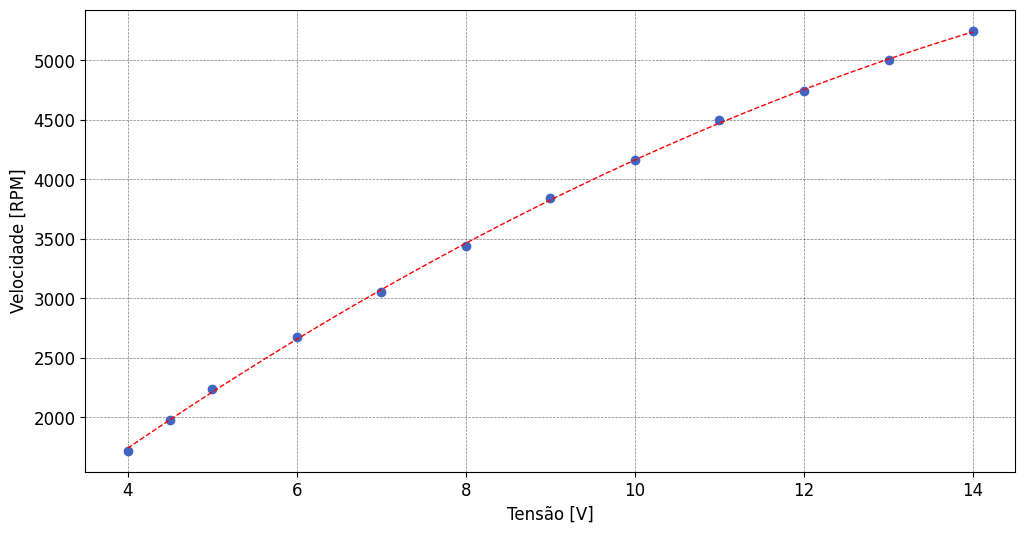

In [6]:
#Ajuste dos dados:
vmot = motpts[0][2:]
nmot = motpts[2][2:]
vreg = np.linspace(vmot[0], vmot[-1], 100)
nreg = np.polyval(np.polyfit(vmot, nmot, 2), vreg)

#Plot:
plt.figure()
plt.plot(vreg, nreg, linestyle='dashed', color='r')
plt.scatter(vmot, nmot)
plt.ylabel('Velocidade [RPM]')
plt.xlabel('Tensão [V]')
plt.show()

### $$ \text{Conferindo linearidade do sistema completo:}$$

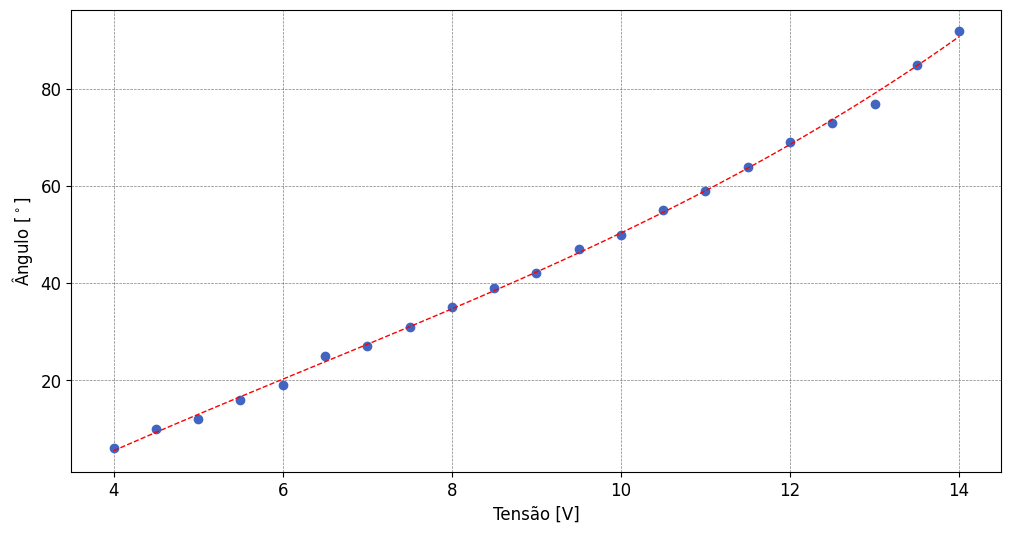

In [7]:
#Ajuste dos dados:
vin = syspts[0]
ang = syspts[1]
vreg = np.linspace(vin[0], vin[-1], 100)
angreg = np.polyval(np.polyfit(vin, ang, 3), vreg)

#Plot:
plt.figure()
plt.plot(vreg, angreg, linestyle='dashed', color='r')
plt.scatter(vin, ang)
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tensão [V]')
plt.show()

### $$ \text{Ensaio de rotor bloqueado (tensão nominal):}$$

Ra = 12.0545297501935
tau_e = 0.00072
La = 0.008679261420139322


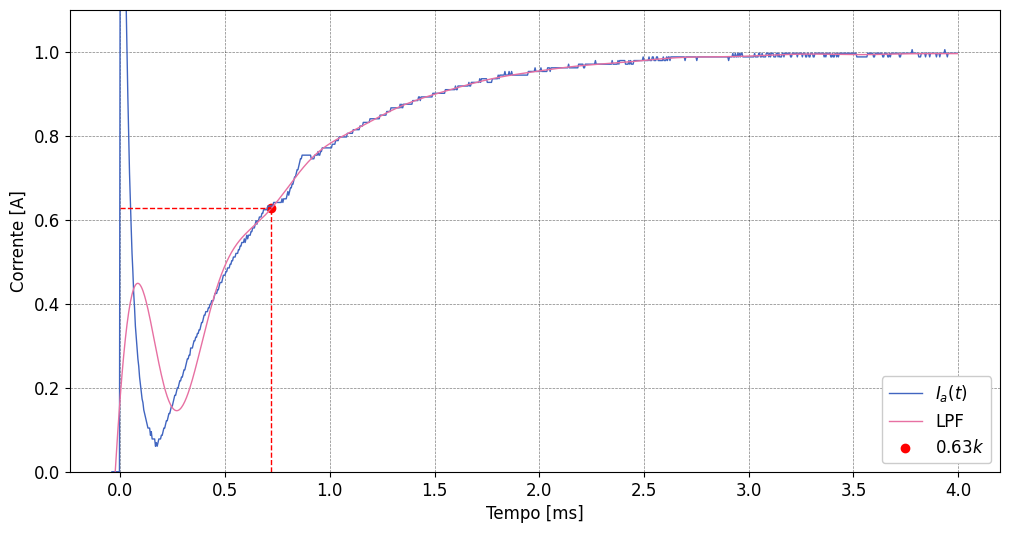

In [8]:
#Carregando curva do osciloscópio:
RB = np.loadtxt('RB\F0002CH1.csv', delimiter=',', unpack=True, dtype='str')
t1 = RB[3].astype(np.float_)[1240:2250]
y1 = RB[4].astype(np.float_)[1240:2250]
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da resistência de armadura:
Ra = (((vt/y1lpf[-1])-1)*Rs)
print(f'Ra = {Ra}')

#Ajuste da corrente pela queda de tensão no shunt:
y1 *= ((1/Ra)+(1/Rs))
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da constante de tempo elétrica:
y163 = 0.63*y1lpf[-1]
taue = t1[index(y1lpf[50:], y163)+50]
print(f'tau_e = {taue}')

#Cálculo da indutância de armadura:
La = taue*Ra
print(f'La = {La}')

#Plot dos dados:
plt.figure()
plt.plot(t1*1e3, y1, label='$I_a(t)$')
plt.plot(t1*1e3, y1lpf, label='LPF')
plt.scatter(taue*1e3, y163, color='r', label='$0.63k$')
plt.plot((0, taue*1e3), (y163, y163), linestyle='dashed', color='r')
plt.plot((taue*1e3, taue*1e3), (0, y163), linestyle='dashed', color='r')
plt.ylim(0, 1.1)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.show()

### $$ \text{Ensaio a vazio (tensão nominal):}$$

tau_m = 0.3639999999999999


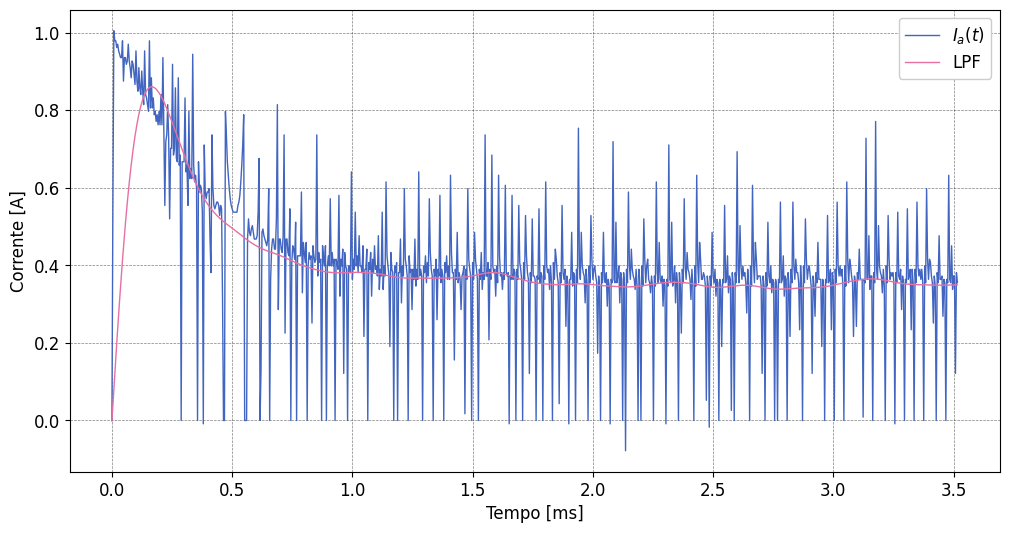

In [9]:
#Carregando curva do osciloscópio:
VZ = np.loadtxt('VZ\F0000CH1.csv', delimiter=',', unpack=True, dtype='str')
t2 = VZ[3].astype(np.float_)[320:1200]-VZ[3].astype(np.float_)[320]
y2 = VZ[4].astype(np.float_)[320:1200]
y2lpf = LPF(y2, 2, 10, 10e2)

#Ajuste da corrente pela queda de tensão no shunt:
y2 *= ((1/Ra)+(1/Rs))
y2lpf = LPF(y2, 2, 10, 10e2)

#Cálculo da constante de tempo mecânica:
y263 = (y2[2]-(0.63*(y2[2]-y2lpf[-1])))
taum = t2[index(y2lpf, y263)]
print(f'tau_m = {taum}')

#Plot dos dados:
plt.figure()
plt.plot(t2, y2, label='$I_a(t)$')
plt.plot(t2, y2lpf, label='LPF')
#plt.ylim(0, 1.1)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.show()

In [10]:
#Cálulo da força contra-eletromotriz:
vb = vt-Ra*y2lpf[-1]
print(f'Vb = {vb}')

#Cálculo da constante magnética e construtiva do motor:
kaphi = (vb/(4740*2*np.pi/60))
print(f'kaphi = {kaphi}')

#Cálculo da perda por ventilação e atrito no motor:
Bm = ((kaphi*y2lpf[-1])/(4740*2*np.pi/60))
print(f'Bm = {Bm}')

#Cálculo do momento de inércia do motor:
Jm = (taum*Bm)
print(f'Jm = {Jm}')

Vb = 7.784515929495702
kaphi = 0.015682837845023306
Bm = 1.1048793882154663e-05
Jm = 4.021760973104296e-06


### $$ \text{Oscilação livre da placa:}$$

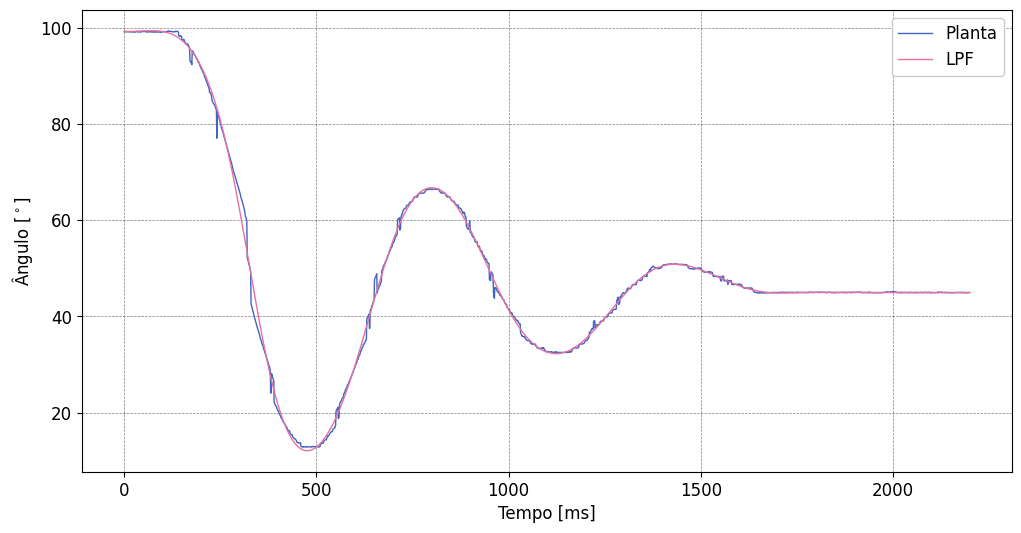

In [11]:
#Decupagem:
tosc = osc[0][800:3000]-osc[0][800]
angosc = osc[1][800:3000]

plt.figure()
plt.plot(tosc*1e3, angosc, label='Planta')
plt.plot(tosc*1e3, LPF(angosc, 4, 5, 1e3), label='LPF')
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.show()